# Causal Analysis: Economic Factors and Employment Outcomes

**MSML610 - Advanced Machine Learning Project**

This notebook analyzes causal effects of macroeconomic indicators on employment outcomes using data from FRED (Federal Reserve Economic Data).

## Project Tasks:
1. Data Preprocessing: Load and time-align economic indicators
2. Causal Discovery: Apply causal-learn (PC, GES, FCI) to identify causal pathways
3. Causal Effect Estimation: Use SEM/regression to quantify effects
4. Temporal Analysis: Analyze how relationships change over time
5. ML Comparison: Compare with Random Forest and LSTM
6. Visualization: Causal DAGs and temporal plots

## Data Source:
- FRED API: Federal Reserve Economic Data
- Free API key: https://fred.stlouisfed.org/docs/api/api_key.html


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


## Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings
import sys
import os
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)

# Project utilities
from utils.utils_data_io import prepare_features_for_causal_discovery
from utils.utils_post_processing import (
    discover_causal_structure,
    estimate_causal_effects,
    visualize_causal_graph,
    temporal_effect_estimation,
    plot_temporal_effects,
    compare_causal_effects
)

# Import modular models
from models import RandomForestModel, LSTMModel, CausalModel

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"Project root: {project_root}")
print("All imports successful (including modular models)")


INFO:utils.utils_post_processing:causal-learn library loaded successfully


Project root: /app
All imports successful (including modular models)


## Step 1: Load Economic Data from FRED

Download macroeconomic data from FRED (Federal Reserve Economic Data).

Variables:
- unemployment_rate: Monthly unemployment rate (%)
- inflation_rate: Year-over-year CPI change (%)
- wage_growth: Year-over-year earnings growth (%)
- gdp_growth: Real GDP growth rate (%)
- federal_funds_rate: Fed funds rate (%)

Setup:
1. Get free API key: https://fred.stlouisfed.org/docs/api/api_key.html
2. Set: export FRED_API_KEY=your_key_here
3. Run: python data/download_data.py


In [3]:
# Load data from FRED
sys.path.insert(0, os.path.join(project_root, 'data'))
from download_data import get_data

# Load cached data or download from FRED
data_path = os.path.join(project_root, 'data', 'economic_data.csv')

if os.path.exists(data_path):
    print("Loading cached data...")
    df = pd.read_csv(data_path, parse_dates=['date'])
else:
    print("No cached data found.")
    print("Run: export FRED_API_KEY=your_key && python data/download_data.py")
    raise FileNotFoundError("Run data/download_data.py first")

print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Columns: {list(df.columns)}")
df.head()


Loading cached data...
Data shape: (311, 12)
Date range: 2000-01-01 00:00:00 to 2025-11-01 00:00:00
Columns: ['date', 'unemployment_rate', 'cpi', 'federal_funds_rate', 'avg_hourly_earnings', 'total_employment', 'gdp_growth_quarterly', 'inflation_rate', 'wage_growth', 'employment_growth', 'real_wage_growth', 'gdp_growth']


,date,unemployment_rate,cpi,federal_funds_rate,avg_hourly_earnings,total_employment,gdp_growth_quarterly,inflation_rate,wage_growth,employment_growth,real_wage_growth,gdp_growth
0,2000-01-01,4.0,169.3,5.45,NaN,131011.0,1.5,NaN,NaN,NaN,NaN,1.500000
1,2000-02-01,4.1,170.0,5.73,NaN,131121.0,NaN,NaN,NaN,NaN,NaN,3.500000
2,2000-03-01,4.0,171.0,5.85,NaN,131604.0,NaN,NaN,NaN,NaN,NaN,5.500000
3,2000-04-01,3.8,170.9,6.02,NaN,131883.0,7.5,NaN,NaN,NaN,NaN,7.500000
4,2000-05-01,4.0,171.2,6.27,NaN,132105.0,NaN,NaN,NaN,NaN,NaN,5.133333


INFO:utils.utils_data_io:Preparing features for causal discovery: ['unemployment_rate', 'inflation_rate', 'wage_growth', 'gdp_growth', 'federal_funds_rate']
INFO:utils.utils_data_io:Prepared 223 observations with 5 variables


DATA SUMMARY

Available variables: ['unemployment_rate', 'inflation_rate', 'wage_growth', 'gdp_growth', 'federal_funds_rate']
Causal data shape: (223, 5)


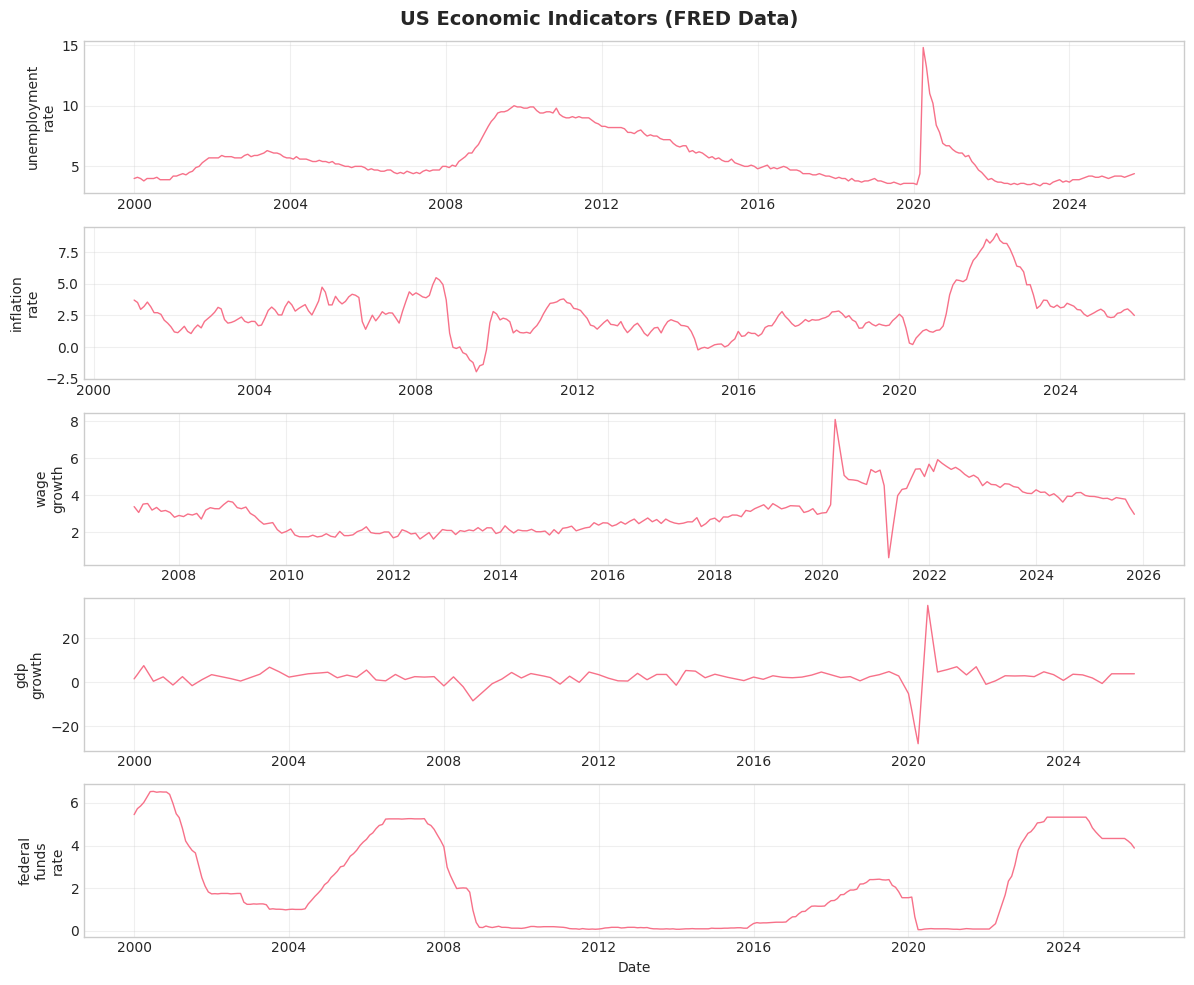


Correlation Matrix:


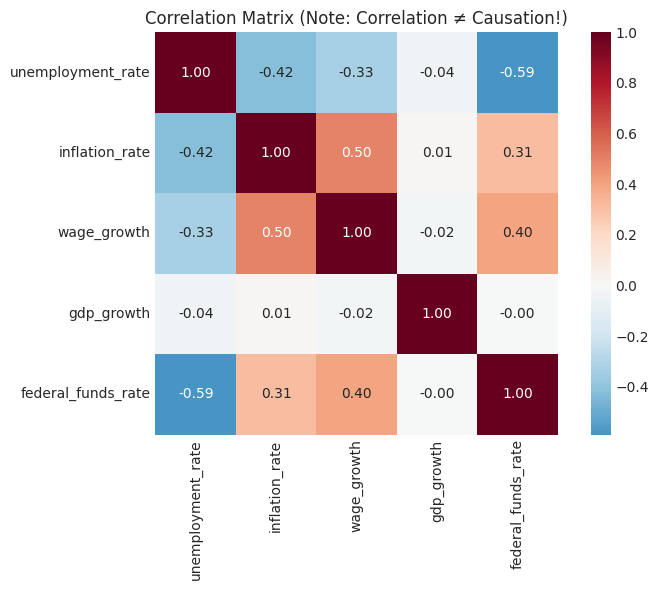

In [4]:
# Explore the data
print("=" * 60)
print("DATA SUMMARY")
print("=" * 60)

# Select key variables for causal analysis
variables = ['unemployment_rate', 'inflation_rate', 'wage_growth', 'gdp_growth', 'federal_funds_rate']

# Check which variables are available
available_vars = [v for v in variables if v in df.columns]
print(f"\nAvailable variables: {available_vars}")

# Prepare data for causal discovery
causal_data = prepare_features_for_causal_discovery(df, available_vars)
print(f"Causal data shape: {causal_data.shape}")

# Plot time series
fig, axes = plt.subplots(len(available_vars), 1, figsize=(12, 2*len(available_vars)))
for i, var in enumerate(available_vars):
    if var in df.columns:
        axes[i].plot(df['date'], df[var], linewidth=1)
        axes[i].set_ylabel(var.replace('_', '\n'))
        axes[i].grid(True, alpha=0.3)
axes[-1].set_xlabel('Date')
plt.suptitle('US Economic Indicators (FRED Data)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation matrix
print("\nCorrelation Matrix:")
corr = causal_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True)
plt.title('Correlation Matrix (Note: Correlation ≠ Causation!)')
plt.tight_layout()
plt.show()


## Step 2: Causal Discovery

Apply PC algorithm (Peter-Clark) to discover causal structure from the data.

The PC algorithm:
- Tests conditional independence between variables
- Constructs a DAG (Directed Acyclic Graph) representing causal relationships
- Significance level α controls edge inclusion (lower α = fewer edges)


In [5]:
# Discover causal structure using PC algorithm
print("=" * 60)
print("CAUSAL DISCOVERY: PC Algorithm")
print("=" * 60)

causal_graph, edges = discover_causal_structure(
    data=causal_data,
    algorithm='PC',
    alpha=0.05,
    variables=available_vars
)

print(f"\nDiscovered {len(edges)} causal relationships:")
for src, tgt in edges:
    print(f"  {src} -> {tgt}")

# Also try GES algorithm for comparison
print("\n" + "-" * 40)
print("Comparison: GES Algorithm")
print("-" * 40)

ges_graph, ges_edges = discover_causal_structure(
    data=causal_data,
    algorithm='GES',
    alpha=0.05,
    variables=available_vars
)

print(f"GES discovered {len(ges_edges)} relationships:")
for src, tgt in ges_edges:
    print(f"  {src} -> {tgt}")

# Find common edges (high confidence)
common = set(edges) & set(ges_edges)
print(f"\nEdges found by BOTH algorithms ({len(common)}):")
for src, tgt in common:
    print(f"  [confirmed] {src} -> {tgt}")


INFO:utils.utils_post_processing:Discovering causal structure using PC algorithm (alpha=0.05)
INFO:utils.utils_post_processing:Running PC on 223 samples with 5 variables
INFO:utils.utils_post_processing:Discovered 4 causal relationships
INFO:utils.utils_post_processing:  unemployment_rate → inflation_rate
INFO:utils.utils_post_processing:  unemployment_rate → federal_funds_rate
INFO:utils.utils_post_processing:  wage_growth → inflation_rate
INFO:utils.utils_post_processing:  wage_growth → federal_funds_rate
INFO:utils.utils_post_processing:Discovering causal structure using GES algorithm (alpha=0.05)
INFO:utils.utils_post_processing:Running GES on 223 samples with 5 variables
INFO:utils.utils_post_processing:Discovered 4 causal relationships
INFO:utils.utils_post_processing:  unemployment_rate → inflation_rate
INFO:utils.utils_post_processing:  unemployment_rate → federal_funds_rate
INFO:utils.utils_post_processing:  inflation_rate → wage_growth
INFO:utils.utils_post_processing:  feder

CAUSAL DISCOVERY: PC Algorithm

Discovered 4 causal relationships:
  unemployment_rate -> inflation_rate
  unemployment_rate -> federal_funds_rate
  wage_growth -> inflation_rate
  wage_growth -> federal_funds_rate

----------------------------------------
Comparison: GES Algorithm
----------------------------------------
GES discovered 4 relationships:
  unemployment_rate -> inflation_rate
  unemployment_rate -> federal_funds_rate
  inflation_rate -> wage_growth
  federal_funds_rate -> wage_growth

Edges found by BOTH algorithms (2):
  [confirmed] unemployment_rate -> inflation_rate
  [confirmed] unemployment_rate -> federal_funds_rate


## Step 3: Visualize Causal Graph

Display the discovered causal structure as a Directed Acyclic Graph (DAG).


INFO:utils.utils_post_processing:Visualizing causal graph: Discovered Causal Structure: Economic Factors → Employment Outcomes


Causal DAG (PC Algorithm):


INFO:utils.utils_post_processing:Saved visualization to /app/outputs/causal_graphs/main_dag.png
INFO:utils.utils_post_processing:Visualizing causal graph: Discovered Causal Structure: Economic Factors → Employment Outcomes


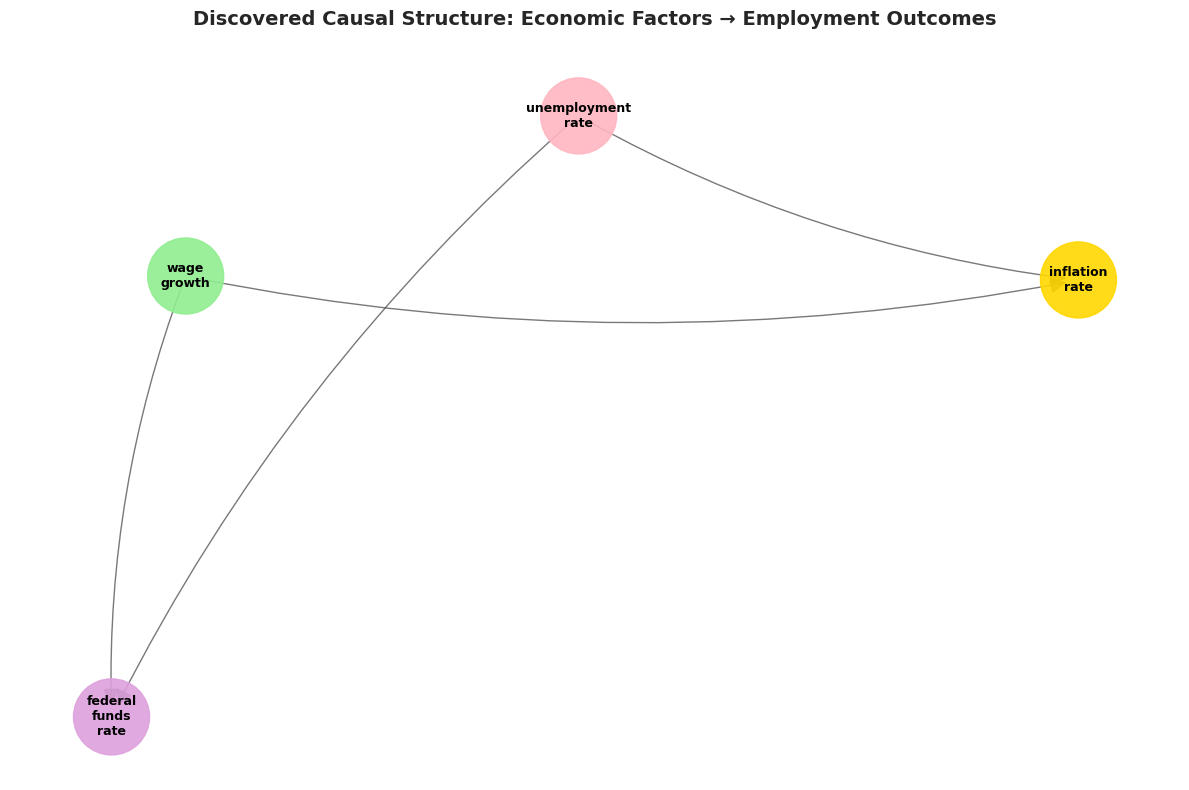


Saved to: outputs/causal_graphs/main_dag.png


In [6]:
# Visualize the causal graph
print("Causal DAG (PC Algorithm):")
visualize_causal_graph(
    graph=causal_graph,
    output_path=os.path.join(project_root, 'outputs', 'causal_graphs', 'main_dag.png'),
    title='Discovered Causal Structure: Economic Factors → Employment Outcomes',
    figsize=(12, 8)
)

# Also display inline
visualize_causal_graph(
    graph=causal_graph,
    output_path=None,
    title='Discovered Causal Structure: Economic Factors → Employment Outcomes',
    figsize=(12, 8)
)
print("\nSaved to: outputs/causal_graphs/main_dag.png")


## Step 4: Causal Effect Estimation

Quantify causal effects using regression adjustment / SEM.

**Key relationships to test:**
- Unemployment → Wage Growth (Phillips Curve: expected negative)
- Inflation → Wage Growth (expected positive for nominal)
- GDP Growth → Unemployment (Okun's Law: expected negative)
- Fed Funds Rate → Inflation (Monetary Policy: expected negative)


In [7]:
# Define treatment-outcome pairs to analyze
causal_pairs = [
    ('unemployment_rate', 'wage_growth', 'Phillips Curve'),
    ('inflation_rate', 'wage_growth', 'Inflation to Wages'),
    ('federal_funds_rate', 'inflation_rate', 'Monetary Policy'),
]

# Filter to available pairs
causal_pairs = [(t, o, d) for t, o, d in causal_pairs 
               if t in causal_data.columns and o in causal_data.columns]

print("=" * 70)
print("CAUSAL EFFECT ESTIMATION")
print("=" * 70)

effects_results = {}

for treatment, outcome, description in causal_pairs:
    print(f"\n{description}: {treatment} -> {outcome}")
    print("-" * 50)
    
    effect = estimate_causal_effects(
        data=causal_data,
        causal_graph=causal_graph,
        treatment=treatment,
        outcome=outcome,
        method='regression'
    )
    
    key = f"{treatment} → {outcome}"
    effects_results[key] = effect
    
    # Interpret
    direction = "positive" if effect['coefficient'] > 0 else "negative"
    sig = "significant" if effect['p_value'] < 0.05 else "not significant"
    
    print(f"  Effect: {effect['coefficient']:.4f}")
    print(f"  95% CI: [{effect['ci_lower']:.4f}, {effect['ci_upper']:.4f}]")
    print(f"  p-value: {effect['p_value']:.4f}")
    print(f"  → {direction.upper()} effect, {sig} at α=0.05")


INFO:utils.utils_post_processing:Estimating causal effect: unemployment_rate → wage_growth using regression
INFO:utils.utils_post_processing:Estimated effect: -0.1727 (95% CI: [-0.2382, -0.1072], p=0.0000)
INFO:utils.utils_post_processing:Estimating causal effect: inflation_rate → wage_growth using regression
INFO:utils.utils_post_processing:Estimated effect: 0.2926 (95% CI: [0.2251, 0.3601], p=0.0000)
INFO:utils.utils_post_processing:Estimating causal effect: federal_funds_rate → inflation_rate using regression
INFO:utils.utils_post_processing:Estimated effect: -0.0411 (95% CI: [-0.1896, 0.1073], p=0.5875)


CAUSAL EFFECT ESTIMATION

Phillips Curve: unemployment_rate -> wage_growth
--------------------------------------------------
  Effect: -0.1727
  95% CI: [-0.2382, -0.1072]
  p-value: 0.0000
  → NEGATIVE effect, significant at α=0.05

Inflation to Wages: inflation_rate -> wage_growth
--------------------------------------------------
  Effect: 0.2926
  95% CI: [0.2251, 0.3601]
  p-value: 0.0000
  → POSITIVE effect, significant at α=0.05

Monetary Policy: federal_funds_rate -> inflation_rate
--------------------------------------------------
  Effect: -0.0411
  95% CI: [-0.1896, 0.1073]
  p-value: 0.5875
  → NEGATIVE effect, not significant at α=0.05


## Step 5: Temporal Analysis

Analyze how causal relationships change over time using rolling windows.


INFO:utils.utils_post_processing:Temporal effect estimation: unemployment_rate → wage_growth
INFO:utils.utils_post_processing:Estimating causal effect: unemployment_rate → wage_growth using regression
ERROR:utils.utils_post_processing:Regression failed: Singular matrix
INFO:utils.utils_post_processing:Estimated effect: 0.0000 (95% CI: [0.0000, 0.0000], p=1.0000)
INFO:utils.utils_post_processing:Estimating causal effect: unemployment_rate → wage_growth using regression
ERROR:utils.utils_post_processing:Regression failed: Singular matrix
INFO:utils.utils_post_processing:Estimated effect: 0.0000 (95% CI: [0.0000, 0.0000], p=1.0000)
INFO:utils.utils_post_processing:Estimating causal effect: unemployment_rate → wage_growth using regression
ERROR:utils.utils_post_processing:Regression failed: Singular matrix
INFO:utils.utils_post_processing:Estimated effect: 0.0000 (95% CI: [0.0000, 0.0000], p=1.0000)
INFO:utils.utils_post_processing:Estimating causal effect: unemployment_rate → wage_growth 

TEMPORAL ANALYSIS: Rolling Window Effects

Analyzed 46 time windows
Effect range: [-1.4679, 0.3893]


INFO:utils.utils_post_processing:Saved temporal plot to /app/outputs/temporal_analysis/temporal_effects.png


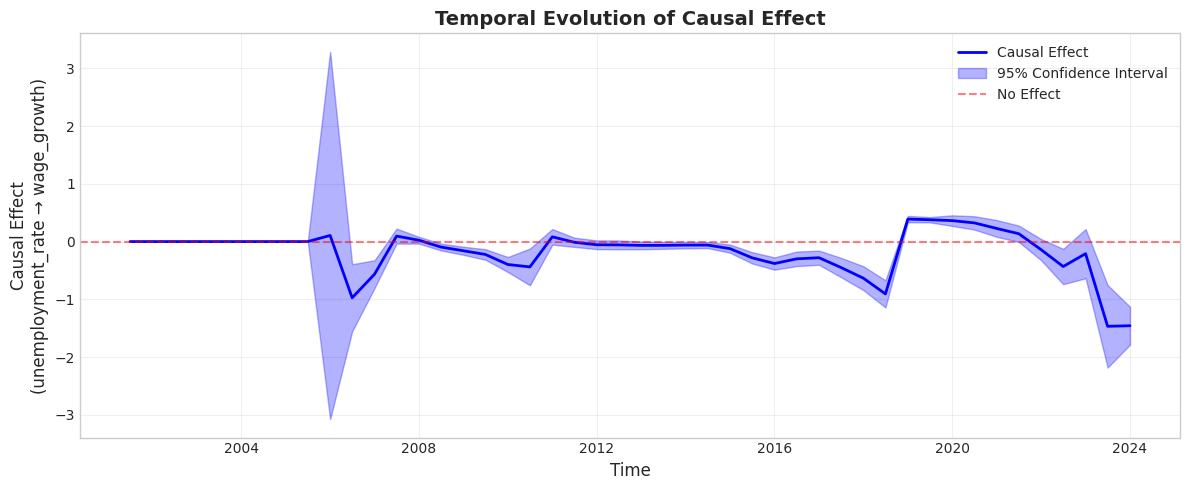


Saved to: outputs/temporal_analysis/temporal_effects.png


In [8]:
# Temporal effect estimation
print("=" * 60)
print("TEMPORAL ANALYSIS: Rolling Window Effects")
print("=" * 60)

# Check if we have enough data for temporal analysis
if 'unemployment_rate' in df.columns and 'wage_growth' in df.columns:
    temporal_results = temporal_effect_estimation(
        data=df,
        window_size=36,  # 3 years
        step_size=6,     # 6 months
        treatment='unemployment_rate',
        outcome='wage_growth',
        time_column='date'
    )
    
    print(f"\nAnalyzed {len(temporal_results['time'])} time windows")
    print(f"Effect range: [{temporal_results['effect'].min():.4f}, {temporal_results['effect'].max():.4f}]")
    
    # Plot temporal effects
    plot_temporal_effects(
        temporal_results=temporal_results,
        treatment='unemployment_rate',
        outcome='wage_growth',
        output_path=os.path.join(project_root, 'outputs', 'temporal_analysis', 'temporal_effects.png'),
        figsize=(12, 5)
    )
    
    # Also show inline
    plot_temporal_effects(
        temporal_results=temporal_results,
        treatment='unemployment_rate',
        outcome='wage_growth',
        output_path=None,
        figsize=(12, 5)
    )
    print("\nSaved to: outputs/temporal_analysis/temporal_effects.png")
else:
    print("Required variables not available for temporal analysis")


## Step 6: ML Model Comparison

Compare causal analysis with predictive ML models (Random Forest).


In [9]:
# ML Comparison using Modular RandomForestModel from models/
# Note: RandomForestModel imported at top of notebook

print("=" * 60)
print("ML MODEL COMPARISON: Random Forest (Modular)")
print("=" * 60)

# Prepare data
feature_cols = [c for c in ['unemployment_rate', 'inflation_rate', 'federal_funds_rate', 'gdp_growth'] 
                if c in causal_data.columns]
target_col = 'wage_growth'

if target_col in causal_data.columns and len(feature_cols) >= 2:
    X = causal_data[feature_cols].dropna()
    y = causal_data.loc[X.index, target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train using modular RandomForestModel from models/
    rf_model = RandomForestModel(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train, y_train, feature_names=feature_cols)
    
    # Evaluate using model's built-in method
    metrics = rf_model.evaluate(X_test, y_test)
    r2 = metrics['r2']
    rmse = metrics['rmse']
    
    print(f"\nRandom Forest Results:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {metrics['mae']:.4f}")
    
    # Get feature importance using model's method
    print(f"\nFeature Importance:")
    importance_df = rf_model.get_feature_importance()
    for _, row in importance_df.iterrows():
        bar = '█' * int(row['importance'] * 30)
        print(f"  {row['feature']:25s} {bar} {row['importance']:.3f}")
    
    print("\n" + "-" * 60)
    print("KEY INSIGHT: Prediction vs Causation")
    print("-" * 60)
    print("- Random Forest tells us WHAT predicts wage growth")
    print("- Causal analysis tells us WHAT CAUSES wage growth")
    print("- High feature importance != Causal effect")
else:
    print("Required variables not available for ML comparison")


INFO:models.random_forest_model:Training RandomForest with 178 samples
INFO:models.random_forest_model:RandomForest training complete


ML MODEL COMPARISON: Random Forest (Modular)

Random Forest Results:
  R² Score: 0.8726
  RMSE: 0.4123
  MAE: 0.2673

Feature Importance:
  inflation_rate            ██████████ 0.346
  federal_funds_rate        ███████ 0.248
  unemployment_rate         ███████ 0.234
  gdp_growth                █████ 0.172

------------------------------------------------------------
KEY INSIGHT: Prediction vs Causation
------------------------------------------------------------
- Random Forest tells us WHAT predicts wage growth
- Causal analysis tells us WHAT CAUSES wage growth
- High feature importance != Causal effect


## Summary and Conclusions


In [10]:
# Final Summary
print("=" * 70)
print("ANALYSIS SUMMARY: Economic Factors and Employment Outcomes")
print("=" * 70)

print("\nDATA:")
print(f"   - Source: FRED (Federal Reserve Economic Data)")
print(f"   - Observations: {len(df)}")
print(f"   - Variables: {len(available_vars)}")

print("\nCAUSAL DISCOVERY:")
print(f"   - PC Algorithm: {len(edges)} causal relationships")
print(f"   - GES Algorithm: {len(ges_edges)} causal relationships")

print("\nKEY CAUSAL EFFECTS:")
for key, effect in effects_results.items():
    sig = "***" if effect['p_value'] < 0.001 else "**" if effect['p_value'] < 0.01 else "*" if effect['p_value'] < 0.05 else ""
    print(f"   - {key}: {effect['coefficient']:.3f} {sig}")

print("\nTEMPORAL ANALYSIS:")
if 'temporal_results' in dir():
    print("   - Effect varies over time (see plot)")
    print("   - Structural relationships may change during economic crises")

print("\nML COMPARISON:")
if 'r2' in dir():
    print(f"   - Random Forest R2: {r2:.3f}")
    print("   - Feature importance != Causal effect")

print("\n" + "=" * 70)
print("Analysis complete. Results saved to outputs/")
print("=" * 70)


ANALYSIS SUMMARY: Economic Factors and Employment Outcomes

DATA:
   - Source: FRED (Federal Reserve Economic Data)
   - Observations: 311
   - Variables: 5

CAUSAL DISCOVERY:
   - PC Algorithm: 4 causal relationships
   - GES Algorithm: 4 causal relationships

KEY CAUSAL EFFECTS:
   - unemployment_rate → wage_growth: -0.173 ***
   - inflation_rate → wage_growth: 0.293 ***
   - federal_funds_rate → inflation_rate: -0.041 

TEMPORAL ANALYSIS:
   - Effect varies over time (see plot)
   - Structural relationships may change during economic crises

ML COMPARISON:
   - Random Forest R2: 0.873
   - Feature importance != Causal effect

Analysis complete. Results saved to outputs/
